# Integrated Analysis: Lost Wallets, PISA Scores, and Social Capital Measures

This notebook combines exploratory data analysis (EDA) of the Lost Wallets dataset with an investigation into the relationship between wallet reporting rates, PISA educational achievement scores, and other survey-based social capital measures. 

The analysis is based on the work by Dave Tannenbaum ([Lost Wallets Social Capital Project](https://github.com/davetannenbaum/lost-wallets-social-capital)) and further explores the connections with international education data (PISA).

## Initial Findings and Context (from `wallet_pisa.ipynb`)

In Dave Tannenbaum's paper, it is shown that:
- Wallet report rates are, in fact, correlated with survey measures of social capital, showing that survey data contains useful information.
- Wallet report rates serve as a predictor in models of "Economic and Institutional Performance", suggesting that social capital as measured by wallet report rates can "explain variation in economic development".

This notebook investigates how education data (PISA scores) relates to these findings. The PISA 2022 reading data was primarily used (source: [OECD PISA 2022 Results Vol I](https://www.oecd.org/en/publications/pisa-2022-results-volume-i_53f23881-en.html), pp. 54-55). It's noted that PISA 2022 data has missing observations for some countries (China, Ghana, India, Kenya, Russia, South Africa). The 2018 PISA data includes China and Russia; China is an outlier with high education scores and low wallet reporting rates. Tannenbaum's paper also noted China as a special case. East Asian countries are generally underrepresented in the wallet dataset.

## 1. Setup and Data Loading

First, we import necessary libraries and load the primary dataset.

In [ ]:
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import chi2_contingency
import numpy as np
from pandas.api.types import is_numeric_dtype
import statsmodels.api as sm
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# pd.set_option('future.no_silent_downcasting', True)
pd.options.mode.chained_assignment = None # default='warn', suppress warning for now

In [47]:
# Define categorical and numerical features for clarity and later use
numeric_features_initial = [
    "general_trust",
    "GPS_trust",
    "general_morality",
    "MFQ_genmorality",
    "civic_cooperation",
    "GPS_posrecip",
    "GPS_altruism",
    "stranger1",
]

cat_cols = [
    "country",
    "response", # Target variable, will be handled separately for modeling
    "male",
    "above40",
    "computer",
    "coworkers",
    "other_bystanders",
    "institution",
    "cond",
    "security_cam",
    "security_guard",
    "local_recipient",
    "no_english",
    "understood_situation",
]

sc_measures = [
    "log_gdp",
    "log_tfp",
    "gee",
    "letter_grading",
]

# Load the dataset
# Assuming the data is in a subdirectory 'lost-wallets-social-capital/data/' relative to the notebook
# If not, adjust the path accordingly.
try:
    df = pd.read_csv(
        "../../lost-wallets-social-capital/data/data_for_ml.csv",
        dtype={col: "category" for col in cat_cols if col != 'response'} # Keep response as object for now, convert later
    )
    df['response'] = df['response'].astype('category') # Now convert response
except FileNotFoundError:
    print("Dataset 'data_for_ml.csv' not found. Please ensure the path is correct.")
    print("You might need to download it from: https://github.com/davetannenbaum/lost-wallets-social-capital")
    df = pd.DataFrame() # Create an empty dataframe to avoid further errors if file not found

if not df.empty:
    print("Dataset loaded successfully.")
    df.head()

Dataset loaded successfully.


## 2. Exploratory Data Analysis (EDA)

Visualizing the distributions of individual features and their relationships.

### 2.1. Feature Distributions
Histograms for continuous variables and bar plots for categorical variables.

In [60]:
# def subplot_subset(data_frame, cols_to_plot, n_subplot_cols=4):
#     """Make a grid of histograms or bar plots for specified columns."""
#     if data_frame.empty or not cols_to_plot:
#         print("Dataframe is empty or no columns to plot.")
#         return
        
#     n_features = len(cols_to_plot)
#     n_rows = (n_features + n_subplot_cols - 1) // n_subplot_cols # Calculate number of rows needed
    
#     fig = make_subplots(rows=n_rows, cols=n_subplot_cols, subplot_titles=cols_to_plot)
    
#     for i, feature in enumerate(cols_to_plot):
#         row_idx = (i // n_subplot_cols) + 1
#         col_idx = (i % n_subplot_cols) + 1
        
#         if pd.api.types.is_numeric_dtype(data_frame[feature]):
#             fig.add_trace(
#                 go.Histogram(x=data_frame[feature], name=feature),
#                 row=row_idx,
#                 col=col_idx,
#             )
#         else: # Categorical
#              # For bar plots, we need counts of each category
#             counts = data_frame[feature].value_counts()
#             fig.add_trace(
#                 go.Bar(x=counts.index, y=counts.values, name=feature),
#                 row=row_idx,
#                 col=col_idx,
#             )
            
#     fig.update_layout(title_text="Feature Distributions", height=300*n_rows, showlegend=False)
#     fig.show()

# if not df.empty:
#     # Visualize first set of features (example)
#     # The original script plots columns by index, which can be fragile.
#     # It's better to explicitly list features or groups of features.
#     print("Displaying distributions for numeric features:")
#     subplot_subset(df, numeric_features_initial)
    
#     # Example for some categorical features (excluding country and response for brevity here)
#     categorical_subset_viz = [col for col in cat_cols if col not in ['country', 'response']][:8] # First 8 for example
#     print("\nDisplaying distributions for a subset of categorical features:")
#     subplot_subset(df, categorical_subset_viz)
    
#     print("\nDisplaying distributions for social capital measures:")
#     subplot_subset(df, sc_measures)

Displaying distributions for numeric features:


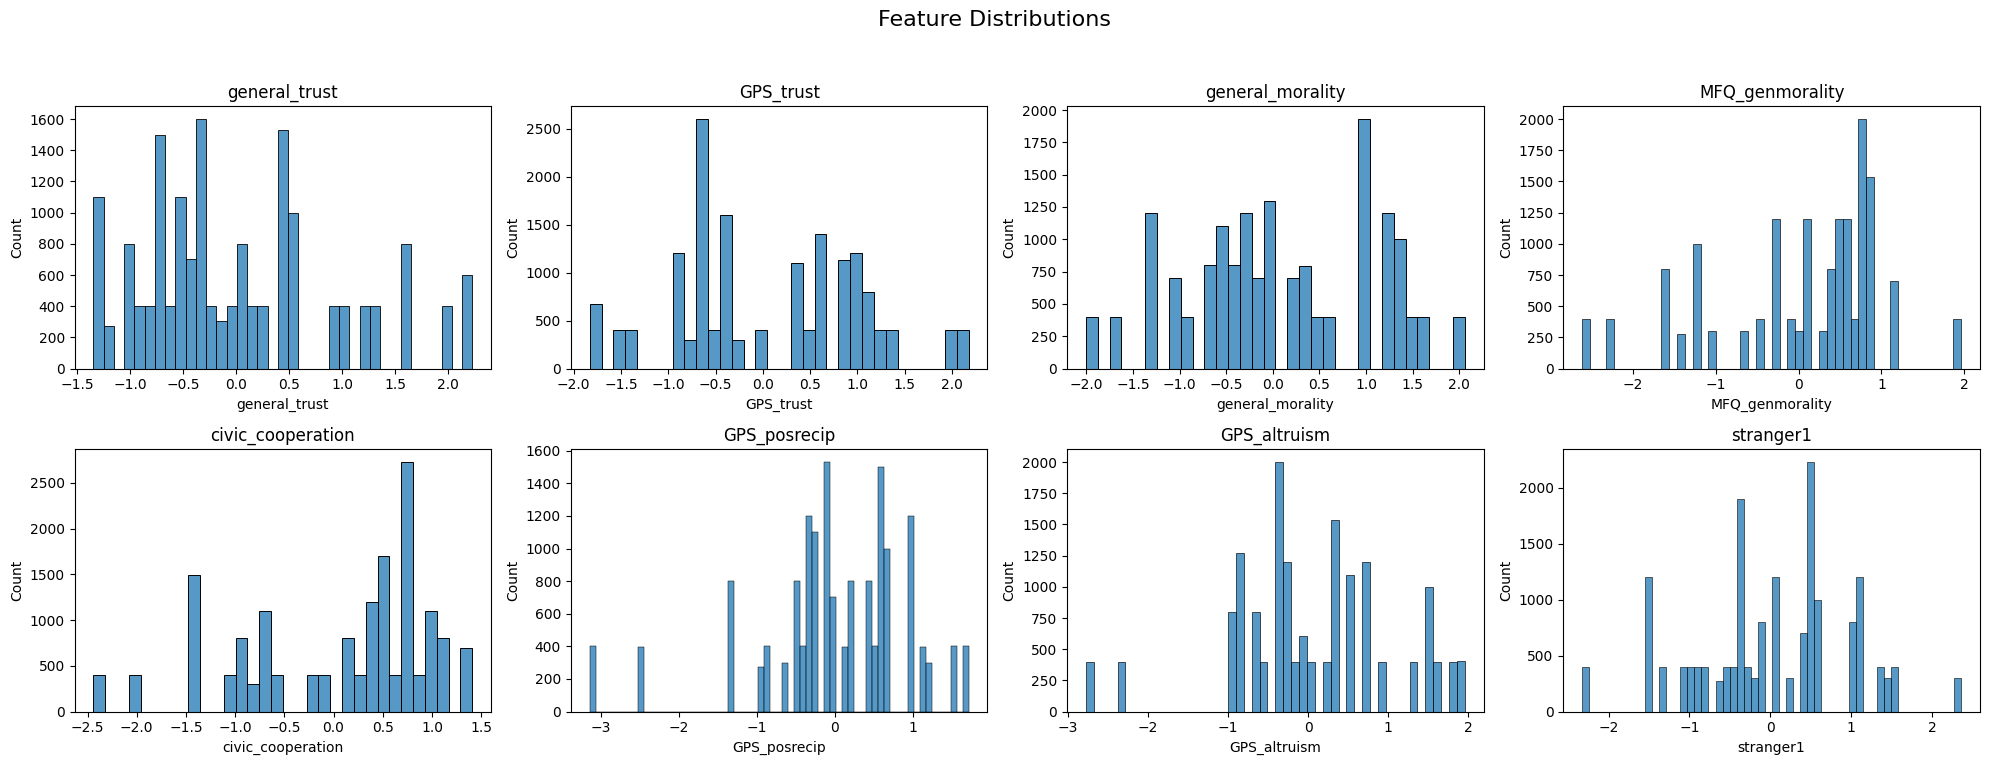


Displaying distributions for a subset of categorical features:


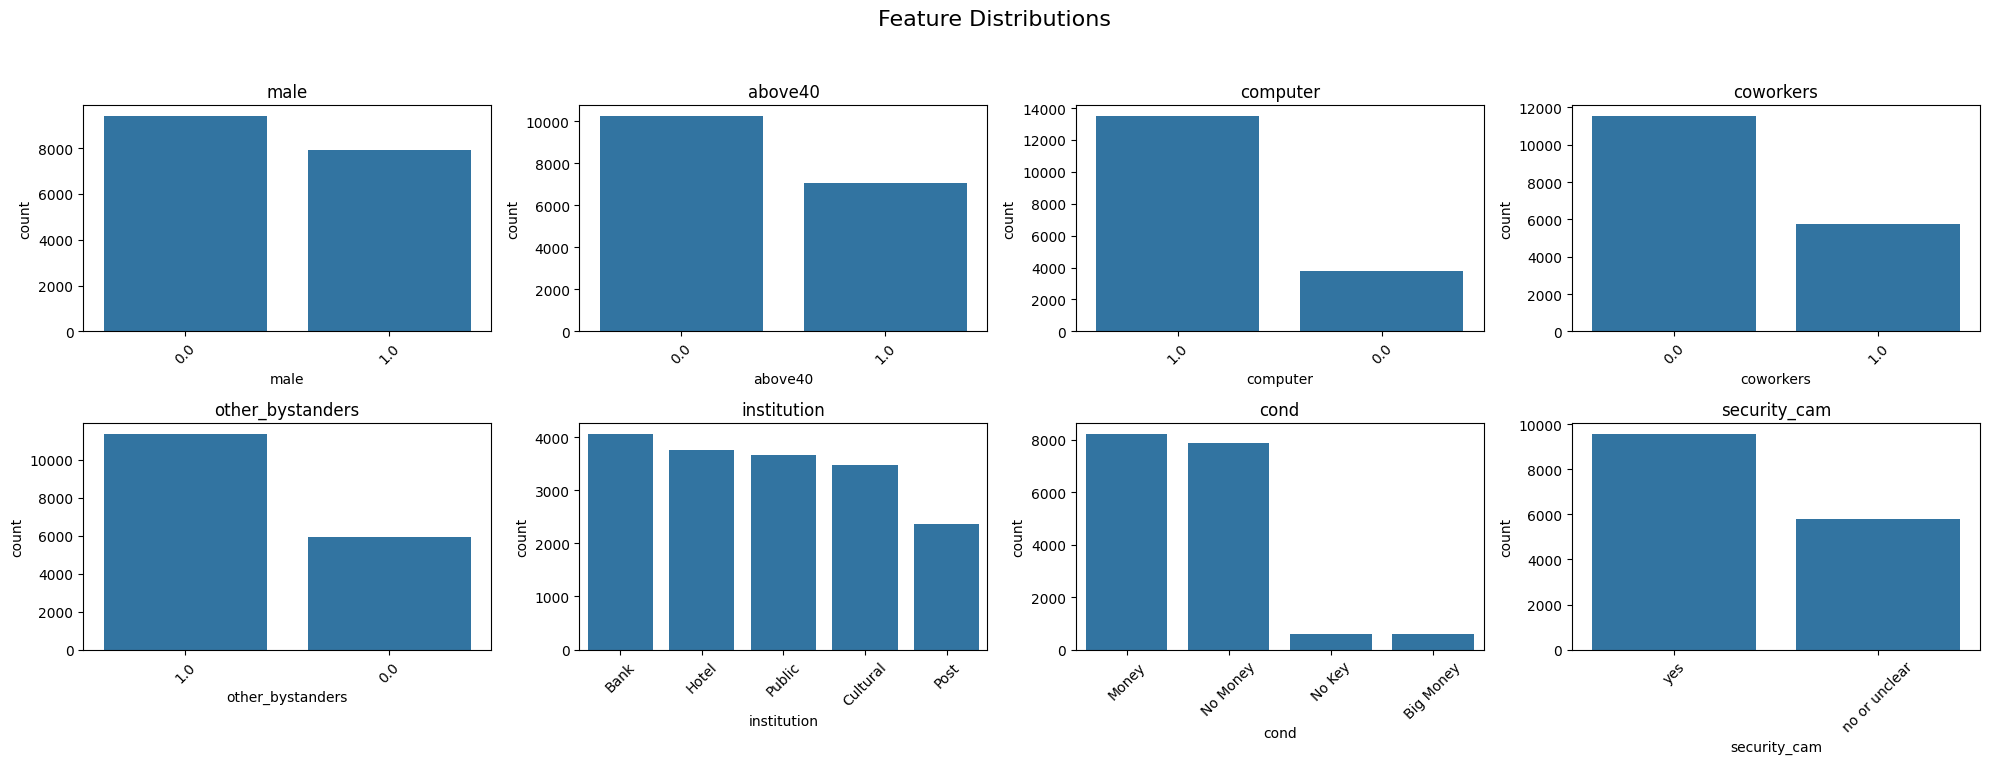


Displaying distributions for social capital measures:


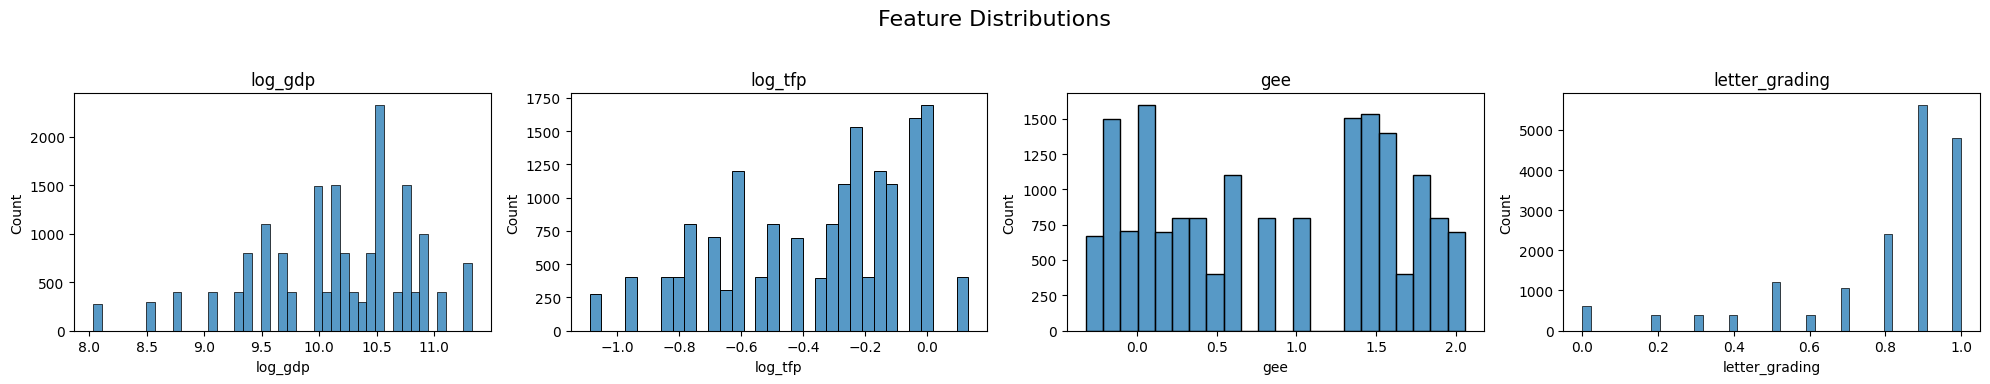

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def subplot_subset_seaborn(data_frame, cols_to_plot, n_subplot_cols=4):
    """Make a grid of histograms or bar plots for specified columns using Seaborn."""
    if data_frame.empty or not cols_to_plot:
        print("Dataframe is empty or no columns to plot.")
        return

    n_features = len(cols_to_plot)
    n_rows = (n_features + n_subplot_cols - 1) // n_subplot_cols

    fig, axes = plt.subplots(n_rows, n_subplot_cols, figsize=(5 * n_subplot_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, feature in enumerate(cols_to_plot):
        ax = axes[i]
        if pd.api.types.is_numeric_dtype(data_frame[feature]):
            sns.histplot(data=data_frame, x=feature, ax=ax, kde=False)
        else:
            sns.countplot(data=data_frame, x=feature, ax=ax,
                          order=data_frame[feature].value_counts().index)
            ax.tick_params(axis='x', rotation=45)

        ax.set_title(feature)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Feature Distributions", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Example usage
if not df.empty:
    print("Displaying distributions for numeric features:")
    subplot_subset_seaborn(df, numeric_features_initial)

    categorical_subset_viz = [col for col in cat_cols if col not in ['country', 'response']][:8]
    print("\nDisplaying distributions for a subset of categorical features:")
    subplot_subset_seaborn(df, categorical_subset_viz)

    print("\nDisplaying distributions for social capital measures:")
    subplot_subset_seaborn(df, sc_measures)

### 2.2. Generalized Association Matrix
To understand relationships between pairs of variables, we compute a generalized correlation matrix. This uses Pearson's correlation for numeric-numeric pairs, correlation ratio for numeric-categorical pairs, and Cramer's V for categorical-categorical pairs.

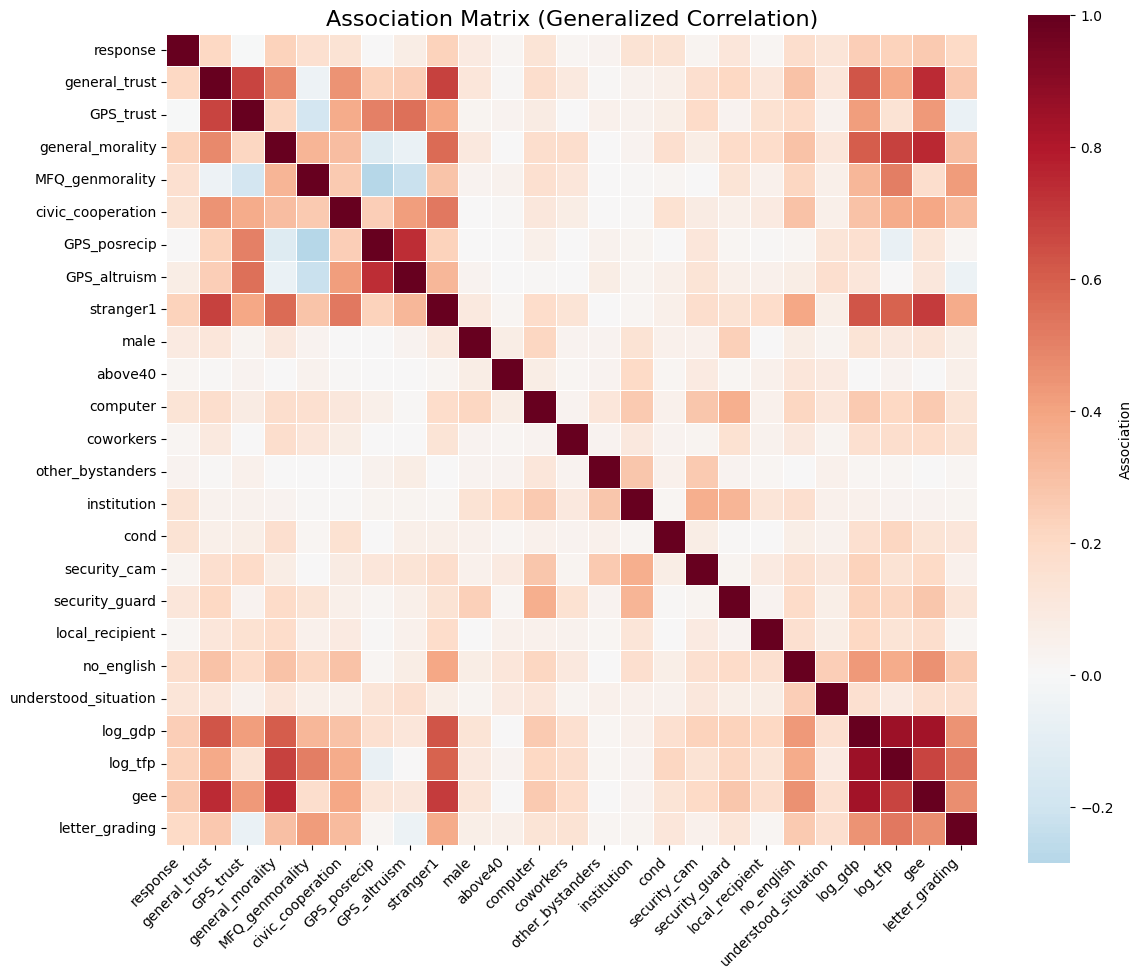

In [50]:
def cramers_v(ex, y_cramer):
    """Cramer correlation between two categorical variables."""
    # Ensure no NaN values, as crosstab will not handle them well for chi2
    ex_nona = ex.dropna()
    y_cramer_nona = y_cramer.dropna()
    # Align indices if they are different after dropping NaNs
    common_index = ex_nona.index.intersection(y_cramer_nona.index)
    ex_nona = ex_nona.loc[common_index]
    y_cramer_nona = y_cramer_nona.loc[common_index]
    
    if ex_nona.empty or y_cramer_nona.empty:
        return 0.0 # Or np.nan if preferred for empty inputs
        
    confusion_matrix = pd.crosstab(ex_nona, y_cramer_nona)
    if confusion_matrix.empty or confusion_matrix.shape[0] == 0 or confusion_matrix.shape[1] == 0:
        return 0.0
        
    chi2_cramers = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    if n == 0:
        return 0.0
        
    phi2 = chi2_cramers / n
    r, k = confusion_matrix.shape
    if min(k - 1, r - 1) == 0:
        return 0.0 # Avoid division by zero if a variable has only one category after filtering
    return np.sqrt(phi2 / min(k - 1, r - 1))

def correlation_ratio(values, categories):
    """Correlation ratio between a categorical and numeric variable."""
    na_mask = values.notna() & categories.notna()
    num_var = values[na_mask]
    cat_var = categories[na_mask]

    if num_var.empty or cat_var.empty or len(cat_var.unique()) < 2:
        return 0.0

    fcat, _ = pd.factorize(cat_var)
    cat_num = np.max(fcat) + 1
    y_avg = num_var.mean()

    numerator = sum(
        len(num_var[fcat == i]) * (num_var[fcat == i].mean() - y_avg) ** 2
        for i in range(cat_num) if len(num_var[fcat == i]) > 0
    )
    denominator = np.sum((num_var - y_avg) ** 2)

    return np.sqrt(numerator / denominator) if denominator != 0 else 0.0

# Compute the generalized association matrix and plot it
if not df.empty:
    df_cols_assoc = df.columns.drop("country", errors="ignore")
    assoc = pd.DataFrame(index=df_cols_assoc, columns=df_cols_assoc, dtype=float)

    for col1 in df_cols_assoc:
        for col2 in df_cols_assoc:
            if col1 == col2:
                assoc.loc[col1, col2] = 1.0
            elif is_numeric_dtype(df[col1]) and is_numeric_dtype(df[col2]):
                corr_val = df[[col1, col2]].corr().iloc[0, 1]
                assoc.loc[col1, col2] = corr_val if pd.notna(corr_val) else 0.0
            elif is_numeric_dtype(df[col1]) and not is_numeric_dtype(df[col2]):
                assoc.loc[col1, col2] = correlation_ratio(df[col1], df[col2])
            elif is_numeric_dtype(df[col2]) and not is_numeric_dtype(df[col1]):
                assoc.loc[col1, col2] = correlation_ratio(df[col2], df[col1])
            else:
                assoc.loc[col1, col2] = cramers_v(df[col1], df[col2])

    assoc = assoc.astype(float)

    # Plot using Seaborn
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        assoc,
        cmap="RdBu_r",
        center=0,
        annot=False,
        fmt=".2f",
        square=True,
        linewidths=0.5,
        cbar_kws={"label": "Association"},
    )
    plt.title("Association Matrix (Generalized Correlation)", fontsize=16)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

else:
    print("DataFrame is empty, skipping association matrix.")

# if not df.empty:
#     df_cols_assoc = df.columns.drop("country") # Excluding country for this matrix, can be too many categories
#     assoc = pd.DataFrame(index=df_cols_assoc, columns=df_cols_assoc, dtype=float)

#     for col1 in df_cols_assoc:
#         for col2 in df_cols_assoc:
#             if col1 == col2:
#                 assoc.loc[col1, col2] = 1.0
#             elif is_numeric_dtype(df[col1]) and is_numeric_dtype(df[col2]):
#                 # Both numeric:
#                 corr_val = df[[col1, col2]].corr().iloc[0, 1]
#                 assoc.loc[col1, col2] = corr_val if pd.notna(corr_val) else 0.0
#             elif is_numeric_dtype(df[col1]) and not is_numeric_dtype(df[col2]):
#                 # First numeric, second categorical:
#                 assoc.loc[col1, col2] = correlation_ratio(df[col1], df[col2])
#             elif is_numeric_dtype(df[col2]) and not is_numeric_dtype(df[col1]):
#                 # First categorical, second numeric:
#                 assoc.loc[col1, col2] = correlation_ratio(df[col2], df[col1])
#             else:
#                 # Both categorical:
#                 assoc.loc[col1, col2] = cramers_v(df[col1], df[col2])

#     assoc = assoc.astype(float)

#     fig_assoc = px.imshow(
#         assoc,
#         labels=dict(x="Features", y="Features", color="Association"),
#         color_continuous_scale="RdBu_r",
#         zmin=-1,
#         zmax=1,
#         aspect="auto",
#     )
#     fig_assoc.update_layout(title_text="Association Matrix (Generalized Correlation)", height=800)
#     fig_assoc.show()
# else:
#     print("DataFrame is empty, skipping association matrix.")

### 2.3. Pairplot for Numeric Features and Response
Visualizing relationships between numeric features, colored by the 'response' variable.

Displaying pairplot for numeric features, colored by response category.


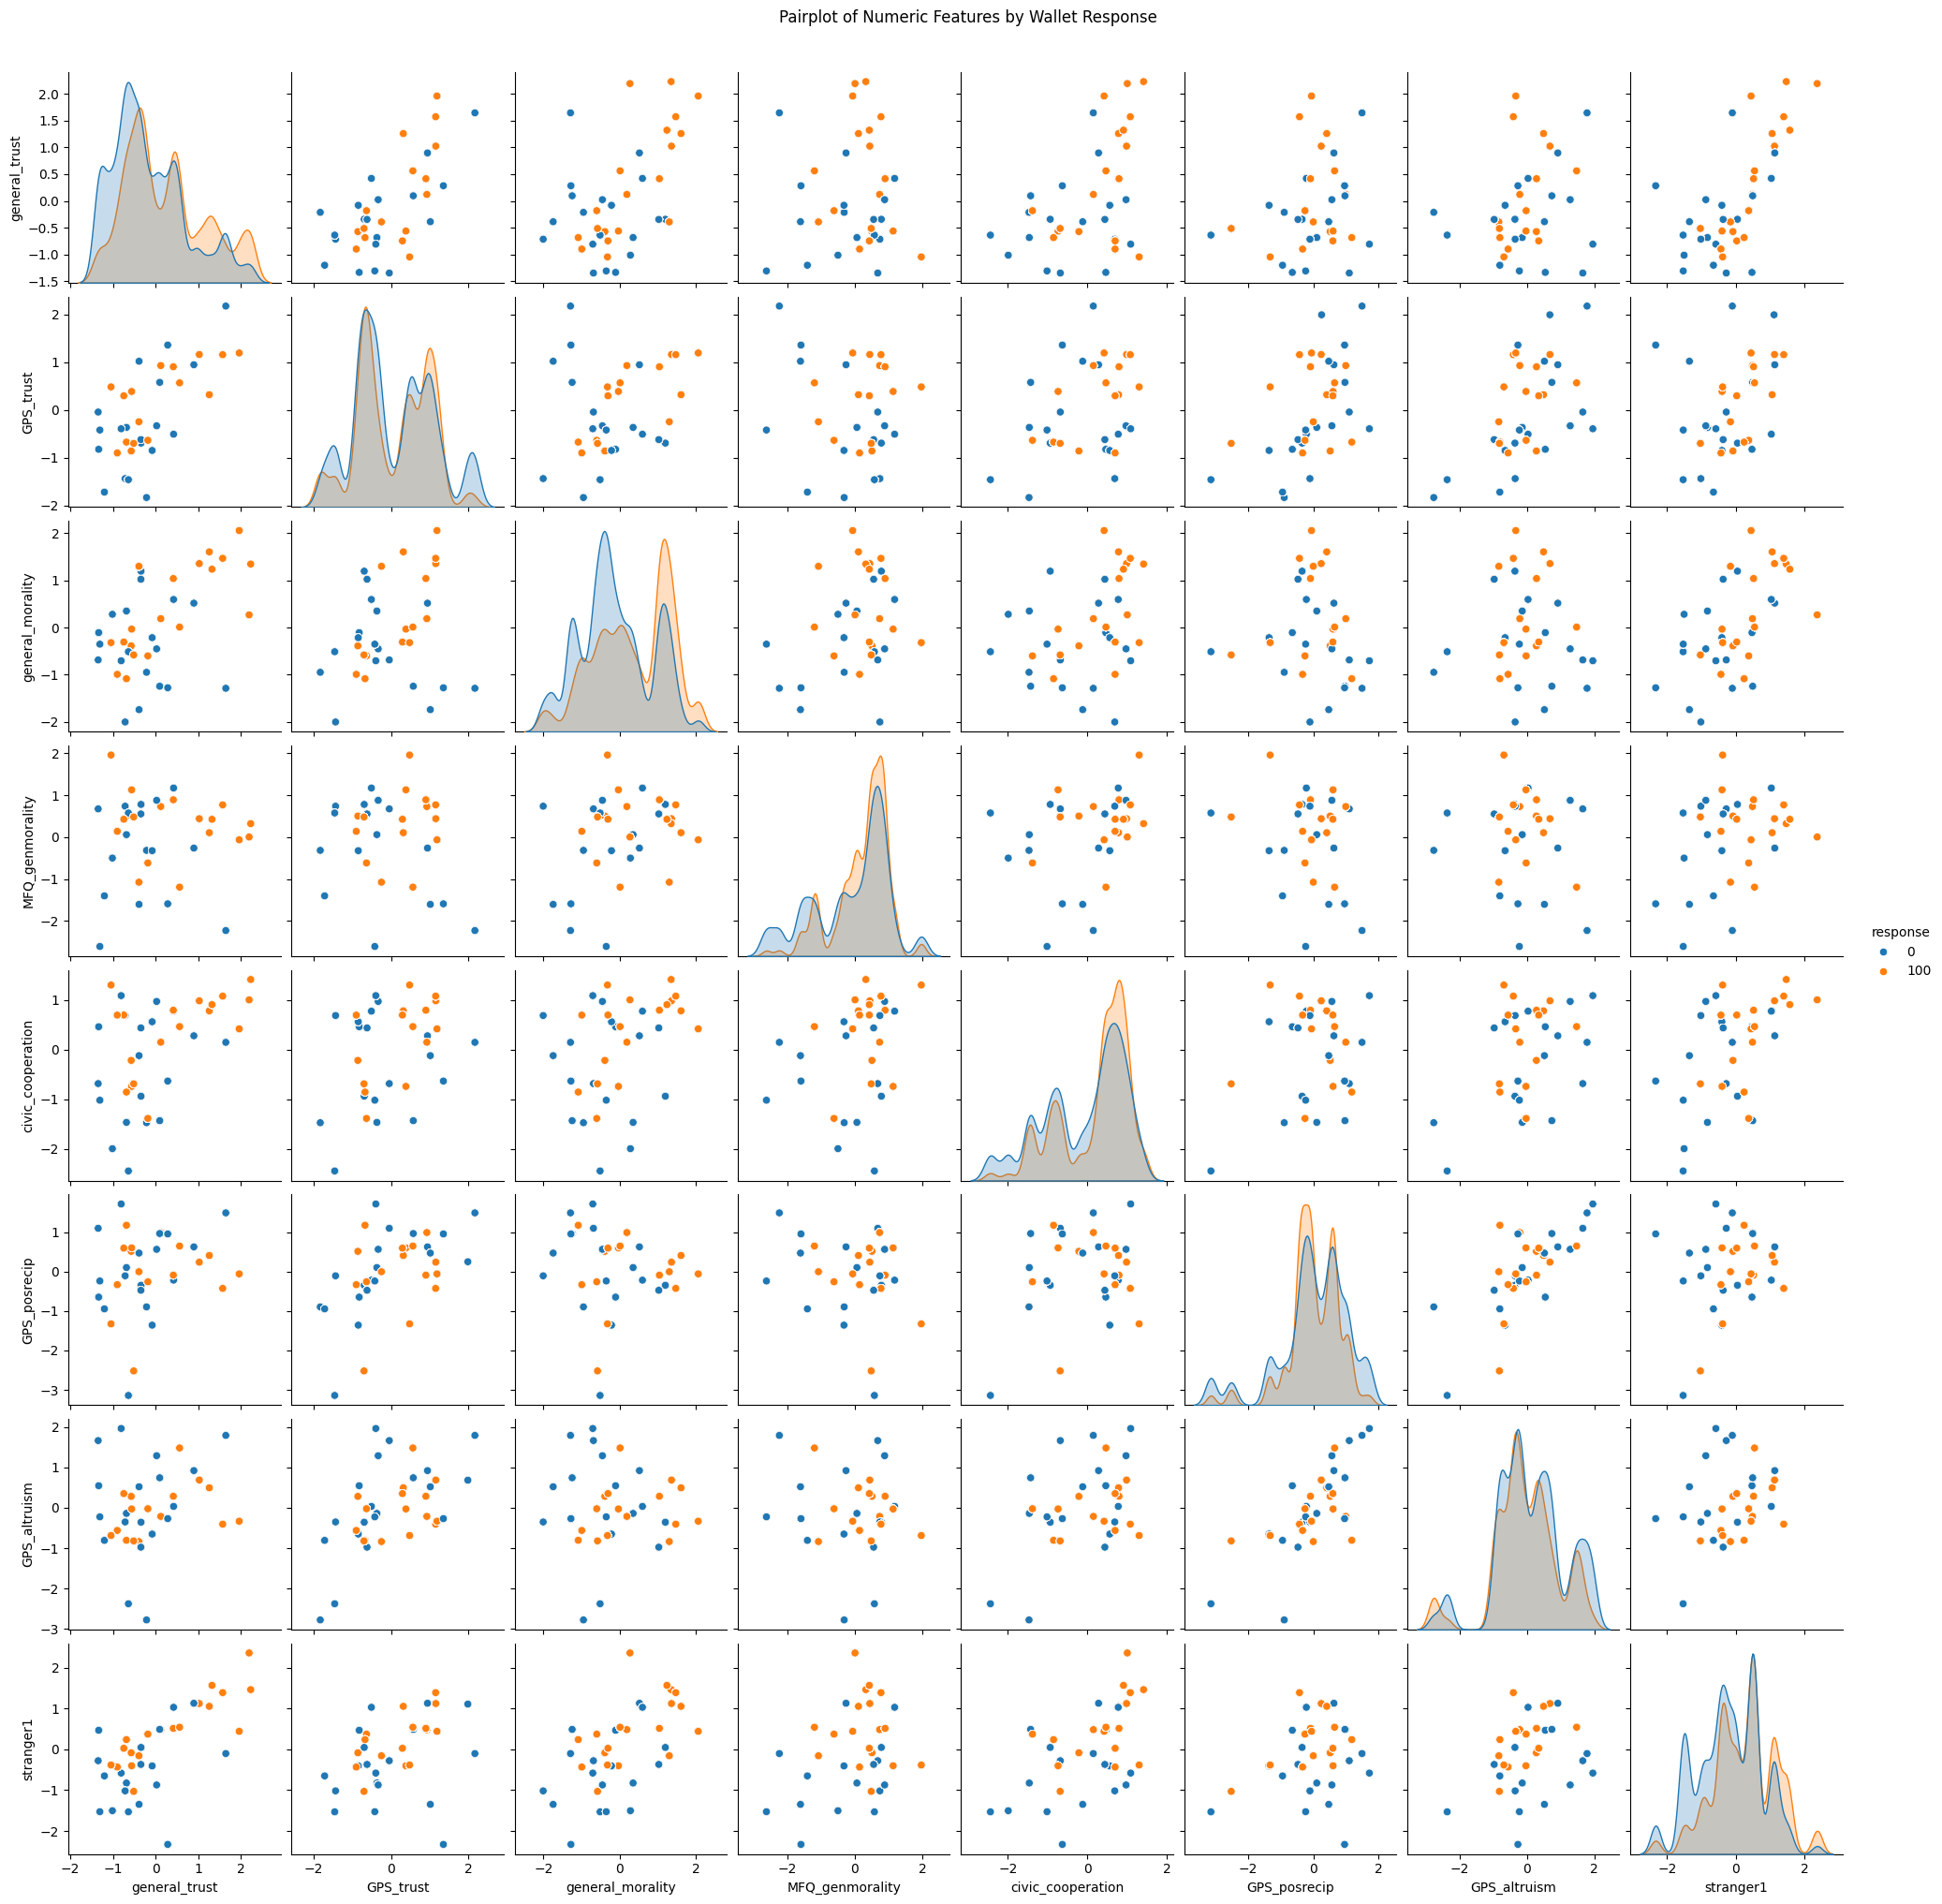

In [27]:
if not df.empty:
    # Ensure 'response' is suitable for hue (categorical)
    # If response is numeric (e.g. 0, 100), convert to string for distinct categories in pairplot hue
    df_pairplot = df.copy()
    if pd.api.types.is_numeric_dtype(df_pairplot['response']):
         df_pairplot['response'] = df_pairplot['response'].astype(str)
    
    print("Displaying pairplot for numeric features, colored by response category.")
    # Adding a check for sufficient data points to avoid errors with pairplot
    if len(df_pairplot) > 1 and len(numeric_features_initial) > 0:
        pairplot_fig = sns.pairplot(df_pairplot[numeric_features_initial + ["response"]], hue="response", diag_kind='kde')
        pairplot_fig.fig.suptitle("Pairplot of Numeric Features by Wallet Response", y=1.02)
        # plt.show() # Use this if running in a local environment where seaborn doesn't auto-show
    else:
        print("Not enough data or numeric features to generate pairplot.")
else:
    print("DataFrame is empty, skipping pairplot.")

## 3. PISA Education Data Integration and Analysis

Loading PISA reading scores and merging them with the wallet dataset to explore correlations.

### 3.1. Loading PISA Data
We load PISA reading scores for 2022 and 2018. The 2022 data is primary, while 2018 is used for countries missing in the 2022 set if needed (though the original script mainly focuses on 2022).

In [51]:
# PISA education data: https://nces.ed.gov/surveys/pisa/idepisa/report.aspx
# The original script uses local Excel files. For reproducibility, it's better to point to URLs if available,
# or ensure the files are in a known relative path (e.g., 'data/' subdirectory).

try:
    pisa_reading_2022 = (
        pd.read_excel(
            "../../data/PISA_reading_2022.xlsx", # Assumes file is in 'data' subdirectory
            skiprows=list(range(0, 11)) + list(range(112, 117)),
            usecols=["Jurisdiction", "Average", "Standard Error"],
            na_values=["†", "—"],
        )
        .dropna(subset=["Average"])
        .rename(columns={"Jurisdiction": "country", "Average": "PISA_Avg_Reading_2022"})
        .replace(
            {
                "Russian Federation": "Russia",
                "United Arab Emirates": "UAE",
                "United Kingdom": "UK",
                "United States": "USA",
            }
        )
        .astype({"PISA_Avg_Reading_2022": float})
    )
    print("PISA 2022 reading data loaded successfully.")
    # print(pisa_reading_2022.head())
except FileNotFoundError:
    print("PISA_reading_2022.xlsx not found in 'data/' subdirectory. Please ensure the file exists.")
    pisa_reading_2022 = pd.DataFrame() 

try:
    pisa_reading_2018 = (
        pd.read_excel(
            "../../data/PISA_reading_2018.xlsx", # Assumes file is in 'data' subdirectory
            skiprows=list(range(0, 11)) + list(range(112, 117)),
            usecols=["Jurisdiction", "Average", "Standard Error"],
            na_values=["†", "—"],
        )
        .dropna(subset=["Average"])
        .rename(columns={"Jurisdiction": "country", "Average": "PISA_Avg_Reading_2018"})
        .replace(
            {
                "B-S-J-Z (China)": "China",
                "Russian Federation": "Russia",
                "United Arab Emirates": "UAE",
                "United Kingdom": "UK",
                "United States": "USA",
            }
        )
        .astype({"PISA_Avg_Reading_2018": float})
    )
    print("PISA 2018 reading data loaded successfully.")
    # print(pisa_reading_2018.head())
except FileNotFoundError:
    print("PISA_reading_2018.xlsx not found in 'data/' subdirectory. Please ensure the file exists.")
    pisa_reading_2018 = pd.DataFrame()

PISA 2022 reading data loaded successfully.
PISA 2018 reading data loaded successfully.


### 3.2. Merging PISA Data with Wallet Data
We calculate wallet reporting rates (proportion of '100' responses) per country and merge this with the PISA data.

In [52]:
if not df.empty and not pisa_reading_2022.empty:
    # Calculate wallet reporting rates (proportion of '100' responses)
    # Ensure 'response' is treated appropriately if it's not already string '0' or '100'
    # The original data seems to use '0' and '100' as strings/categories.
    wallet_rates = (
        df.groupby("country", observed=True)["response"]
        .value_counts(normalize=True)
        .rename('proportion') # Rename before unstacking
        .unstack(fill_value=0) # Fill with 0 if a category ('0' or '100') is missing for a country
    )
    
    # Select the proportion for '100' responses. Handle if '100' column doesn't exist for some reason.
    if '100' in wallet_rates.columns:
        wallet_rates = wallet_rates[['100']].reset_index().rename(columns={"100": "wallet_return_rate"})
    elif 100 in wallet_rates.columns: # If it was numeric
        wallet_rates = wallet_rates[[100]].reset_index().rename(columns={100: "wallet_return_rate"})
    else:
        print("Column '100' for response not found in wallet_rates. Check response values.")
        # Create an empty df to avoid errors, or handle as appropriate
        wallet_rates = pd.DataFrame(columns=['country', 'wallet_return_rate'])

    # Merge with PISA 2022 data
    reading_wallets = pisa_reading_2022.merge(wallet_rates, how="inner", on="country")
    # reading_wallets = reading_wallets.set_index("country") # Set index later if needed for specific plots/analyses

    print("Wallet rates merged with PISA 2022 data:")
    print(reading_wallets.head())

    # Correlation between PISA scores and wallet return rate
    if 'PISA_Avg_Reading_2022' in reading_wallets.columns and 'wallet_return_rate' in reading_wallets.columns:
        correlation_pisa_wallet = reading_wallets[["PISA_Avg_Reading_2022", "wallet_return_rate"]].corr()
        print("\nCorrelation between PISA 2022 Reading Scores and Wallet Return Rate:")
        print(correlation_pisa_wallet)

        # Scatter plot
        # fig_scatter_pisa_wallet = px.scatter(
        #     reading_wallets.reset_index(), 
        #     x="wallet_return_rate", 
        #     y="PISA_Avg_Reading_2022", 
        #     hover_data=["country"],
        #     title="PISA 2022 Reading Score vs. Wallet Return Rate by Country",
        #     trendline="ols" # Add a regression line
        # )
        # fig_scatter_pisa_wallet.show()
    else:
        print("Required columns for PISA vs Wallet correlation are missing.")
else:
    print("Skipping PISA data merging and analysis as main df or PISA df is empty.")
    reading_wallets = pd.DataFrame() # Ensure it exists for later cells

Wallet rates merged with PISA 2022 data:
          country  PISA_Avg_Reading_2022  Standard Error  wallet_return_rate
0       Australia             498.050940        2.013591            0.606516
1          Canada             507.132896        1.965629            0.550000
2           Chile             447.978957        2.632560            0.361111
3  Czech Republic             488.603669        2.246224            0.700000
4         Denmark             488.800991        2.578275            0.750000

Correlation between PISA 2022 Reading Scores and Wallet Return Rate:
                       PISA_Avg_Reading_2022  wallet_return_rate
PISA_Avg_Reading_2022                1.00000             0.78018
wallet_return_rate                   0.78018             1.00000


### 3.3. Commentary on PISA, Wallets, and Survey Measures (from `wallet_pisa.ipynb`)

**Tannenbaum Point 1 Context:**
The Tannenbaum paper aimed to validate survey measures of social capital using wallet report rates. Similarly, PISA education measures could also be seen as validating these survey measures. It's interesting that the relationship between PISA scores and survey measures is very similar to that between wallet report rates and survey measures.

A key observation was the strong correlation between PISA reading scores and wallet reporting rates (rho ≈ 0.78 with 2022 data). This is greater than the correlation with many other "Economic and Institutional Performance" measures. This suggests a close link between societal honesty (as measured by wallet returns) and educational outcomes.

**Takeaways/Thoughts:**
- Both honesty and education are challenging to influence directly through policy. The strong correlation might suggest that familial and community factors (components of social capital) are highly influential for educational outcomes.
- Wallet report rates are a direct behavioral measure of social capital. While PISA scores are measures of institutional (educational system) performance, their strong correlation with wallet rates might imply they also reflect aspects of broader social capital.

### 3.4. Correlation Matrix including PISA, Wallet Response, Survey Measures, and SC Measures

In [53]:
# if not df.empty and not pisa_reading_2022.empty:
#     # Prepare data for comprehensive correlation matrix
#     # Convert 'response' in the main df to numeric (e.g., 0 or 100) for correlation
#     df_corr_prep = df.copy()
#     # Assuming response categories are '0' and '100'. If they are already numeric, this won't harm.
#     # If they are other categories, this mapping needs adjustment.
#     if df_corr_prep['response'].dtype == 'category' or df_corr_prep['response'].dtype == 'object':
#         # Attempt to convert to numeric, coercing errors for non-numeric strings
#         df_corr_prep['response_numeric'] = pd.to_numeric(df_corr_prep['response'], errors='coerce')
#         # A common case is '0' and '100' as categories. If so, this works.
#         # If it's like 'returned', 'not_returned', map them, e.g. {'returned':100, 'not_returned':0}
#         # For this dataset, '0' and '100' are the categories, so direct numeric conversion is fine.
#     else:
#         df_corr_prep['response_numeric'] = df_corr_prep['response']
    
#     df_merged_for_corr = df_corr_prep.merge(pisa_reading_2022[['country', 'PISA_Avg_Reading_2022']], how='left', on='country')
    
#     cols_for_country_avg_corr = ['response_numeric', 'PISA_Avg_Reading_2022'] + numeric_features_initial + sc_measures
    
#     # Calculate country averages for these measures
#     country_avg_data = df_merged_for_corr.groupby("country", observed=False)[cols_for_country_avg_corr].mean()
    
#     # Compute the correlation matrix
#     comprehensive_corr_matrix = country_avg_data.corr()

#     print("\nComprehensive Correlation Matrix (Country Averages):")
#     print(comprehensive_corr_matrix)

#     # Visualize the correlation matrix
#     fig_comp_corr = px.imshow(
#         comprehensive_corr_matrix,
#         labels=dict(color="Correlation"),
#         color_continuous_scale="RdBu_r",
#         zmin=-1,
#         zmax=1,
#         title="Correlation Matrix: Wallet Response, PISA, Survey & SC Measures (Country Averages)",
#         text_auto=True # Show correlation values on heatmap
#     )
#     fig_comp_corr.update_layout(height=800)
#     fig_comp_corr.show()
# else:
#     print("Skipping comprehensive correlation matrix as main df or PISA df is empty.")

**Observations from the Correlation Matrix:**
1. PISA scores (`PISA_Avg_Reading_2022`) generally show stronger correlations with wallet `response_numeric` than many individual survey-based social capital measures do.
2. PISA scores also correlate with other macro social capital indicators (`log_gdp`, `gee`, etc.), sometimes more strongly than the wallet response rate itself does. This might suggest PISA scores capture a broad aspect of societal development and functional institutions, which overlaps with social capital.
3. The survey measures (like `general_trust`, `general_morality`) show varied correlations with both wallet response and PISA scores, reinforcing the idea that these are related but distinct constructs.

### 3.5. Regression Analysis: Predictive Value of Wallet Return Rate for PISA Scores (from `wallet_eda.py`)
Investigating if wallet return rates, when combined with other survey measures, significantly predict PISA scores. This explores Tannenbaum's second point regarding predictive power, but with PISA as the outcome.

In [54]:
if not reading_wallets.empty and not df.empty:
    print("\nRegression Analysis: Predicting PISA Scores")
    print("Outcome variable: PISA_Avg_Reading_2022")
    print("Predictors: wallet_return_rate and one survey_measure at a time\n")
    
    # Ensure reading_wallets has 'country' as a column for merging, not index
    reading_wallets_reg = reading_wallets.copy()
    if reading_wallets_reg.index.name == 'country':
        reading_wallets_reg = reading_wallets_reg.reset_index()

    for measure in numeric_features_initial: # Using the initial numeric features as survey_measures
        # Get country-level average for the current survey measure
        country_avg_measure = df.groupby('country', observed=False)[[measure]].mean().reset_index()
        
        # Merge PISA/wallet data with the current survey measure average
        regression_df = pd.merge(reading_wallets_reg, country_avg_measure, on='country', how='inner')
        regression_df = regression_df.dropna(subset=['PISA_Avg_Reading_2022', 'wallet_return_rate', measure])

        if len(regression_df) < 3: # Need enough data points for regression
            print(f"Skipping regression for {measure} due to insufficient data after merge/dropna ({len(regression_df)} rows).")
            continue

        y = regression_df["PISA_Avg_Reading_2022"]
        X = regression_df[[measure, "wallet_return_rate"]]
        
        # Standardize predictors for better comparison of coefficients if desired, though OLS doesn't strictly require it
        X_std = (X - X.mean()) / X.std()
        X_std = sm.add_constant(X_std) # Add intercept

        try:
            model = sm.OLS(y, X_std)
            results = model.fit(cov_type="HC1") # Robust standard errors
            print(f"\n--- Regression Summary for PISA ~ {measure} + wallet_return_rate ---")
            print(results.summary())
        except Exception as e:
            print(f"Error during regression for {measure}: {e}")
            print(f"Data for {measure}:\n y_head: {y.head()}\n X_std_head:\n{X_std.head()}")
else:
    print("Skipping regression analysis as reading_wallets or main df is empty.")


Regression Analysis: Predicting PISA Scores
Outcome variable: PISA_Avg_Reading_2022
Predictors: wallet_return_rate and one survey_measure at a time


--- Regression Summary for PISA ~ general_trust + wallet_return_rate ---
                              OLS Regression Results                             
Dep. Variable:     PISA_Avg_Reading_2022   R-squared:                       0.604
Model:                               OLS   Adj. R-squared:                  0.577
Method:                    Least Squares   F-statistic:                     26.93
Date:                   Sat, 31 May 2025   Prob (F-statistic):           2.01e-07
Time:                           16:22:03   Log-Likelihood:                -157.19
No. Observations:                     33   AIC:                             320.4
Df Residuals:                         30   BIC:                             324.9
Df Model:                              2                                         
Covariance Type:                     H

**Commentary on Regression (from `wallet_pisa.ipynb` - Tannenbaum Point 2 Context):**
The Tannenbaum paper discusses four measures of "Economic and Institutional Performance": GDP per capita (`log_gdp`), productivity (`log_tfp`), government effectiveness (`gee`), and letter grade efficiency (`letter_grading`). If PISA scores are considered a fifth measure of this type, the analysis above suggests that wallet reporting rates can be an effective predictor.

When wallet reporting rates are combined with other survey measures of social capital (as in the regressions above), the coefficient for wallet reporting rates often remains statistically significant. This implies that the behavioral measure (wallet returns) offers predictive power for educational outcomes (PISA scores) beyond what is captured by attitudinal survey measures alone. The R-squared values from these models can be compared to those in Tannenbaum's paper for other institutional outcomes.

## 4. Machine Learning: Predicting Wallet Response

Building models to predict whether a wallet is reported based on various features. We'll first use the original features, then incorporate PISA scores to see if they improve predictive accuracy (at an individual prediction level, which is a different task than country-level prediction/correlation).

### 4.1. Preprocessing and Model without PISA Data

In [55]:
if not df.empty:
    # Define features for this model
    numeric_features_ml1 = [
        "general_trust", "GPS_trust", "general_morality", "MFQ_genmorality",
        "civic_cooperation", "GPS_posrecip", "GPS_altruism", "stranger1"
    ]
    categorical_features_ml1 = [
        "male", "above40", "computer", "coworkers", "other_bystanders", 
        "institution", "cond"
        # Excluding other categorical features like security_cam, etc. as in original script for this part
    ]

    # Numeric feature pipeline
    numeric_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
    )

    # Categorical feature pipeline
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")), # Added imputer for categorical
            ("encoder", OneHotEncoder(handle_unknown="ignore")),
            # SelectPercentile for categorical features after OHE might be less common than for numeric.
            # Chi2 requires non-negative features, which OHE provides.
            ("selector", SelectPercentile(chi2, percentile=50)) 
        ]
    )

    preprocessor1 = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features_ml1),
            ("cat", categorical_transformer, categorical_features_ml1),
        ]
    )

    # Target variable: needs to be numeric for scikit-learn classifiers
    # Assuming 'response' categories are '0' and '100'. We map them to 0 and 1.
    y = df["response"].cat.codes # This will map '0' to 0 and '100' to 1 if these are the categories
    X = df.drop(columns="response")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=23, stratify=y # Stratify by y for classification
    )

    # Example classifier: SVC (as in original script)
    # The original script tested various classifiers; SVC with class_weight='balanced' was highlighted.
    clf1 = Pipeline(
        steps=[
            ("preprocessor", preprocessor1),
            ("classifier", SVC(random_state=123, class_weight="balanced"))
        ]
    )

    # Weighting observations (as explored in original script)
    # This was an experiment; its effectiveness can vary.
    cond_counts = X_train["cond"].value_counts(normalize=True)
    weights = X_train["cond"].map(lambda x: 1 / cond_counts[x] if x in cond_counts else 1.0)

    try:
        clf1.fit(X_train, y_train, classifier__sample_weight=weights)
        score1 = clf1.score(X_test, y_test)
        print(f"Model 1 (without PISA) score: {score1:.3f}")
    except Exception as e:
        print(f"Error fitting Model 1: {e}")
        print("Check feature lists and preprocessor compatibility with selected classifier.")

else:
    print("DataFrame is empty, skipping ML model training.")

Model 1 (without PISA) score: 0.680


### 4.2. Preprocessing and Model with PISA Data (and other SC measures)
Here, we add country-level PISA scores and other social capital measures (`sc_measures`) to the feature set. Note that PISA scores are country-level, so they will be constant for all individuals within the same country. This might limit their predictive power for individual responses but is included as per the original exploration.

In [56]:
if not df.empty and not pisa_reading_2022.empty:
    df_with_pisa = df.merge(pisa_reading_2022[['country', 'PISA_Avg_Reading_2022']], how="left", on="country")
    # Impute PISA scores if some countries in df don't have them (e.g., with mean PISA score)
    df_with_pisa['PISA_Avg_Reading_2022'] = df_with_pisa['PISA_Avg_Reading_2022'].fillna(df_with_pisa['PISA_Avg_Reading_2022'].mean())

    numeric_features_ml2 = numeric_features_initial + sc_measures + ['PISA_Avg_Reading_2022']
    # Ensure all numeric features actually exist in df_with_pisa and are numeric
    valid_numeric_features_ml2 = []
    for col in numeric_features_ml2:
        if col in df_with_pisa.columns and pd.api.types.is_numeric_dtype(df_with_pisa[col]):
            valid_numeric_features_ml2.append(col)
        elif col in df_with_pisa.columns: # If column exists but not numeric, try to convert
            df_with_pisa[col] = pd.to_numeric(df_with_pisa[col], errors='coerce')
            if pd.api.types.is_numeric_dtype(df_with_pisa[col]):
                 valid_numeric_features_ml2.append(col)
            else:
                print(f"Warning: Column '{col}' could not be converted to numeric and will be excluded from numeric features for ML.")
        else:
            print(f"Warning: Column '{col}' not found in dataframe and will be excluded from numeric features for ML.")
    numeric_features_ml2 = valid_numeric_features_ml2
    
    # Categorical features from original script for this model
    categorical_features_ml2 = [
        "male", "above40", "computer", "coworkers", "other_bystanders", 
        "institution", "cond", "security_cam", "security_guard", 
        "local_recipient", "no_english", "understood_situation"
    ]
    valid_categorical_features_ml2 = [col for col in categorical_features_ml2 if col in df_with_pisa.columns]
    categorical_features_ml2 = valid_categorical_features_ml2

    # Numeric transformer (can reuse the previous one if strategy is the same)
    numeric_transformer_ml2 = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
    )

    # Categorical transformer (can reuse)
    categorical_transformer_ml2 = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore")),
            ("selector", SelectPercentile(chi2, percentile=50)), 
        ]
    )

    preprocessor2 = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer_ml2, numeric_features_ml2),
            ("cat", categorical_transformer_ml2, categorical_features_ml2),
        ],
        remainder='drop' # Drop any columns not specified
    )

    # Target variable
    y2 = df_with_pisa["response"].cat.codes
    X2 = df_with_pisa.drop(columns="response")

    X_train2, X_test2, y_train2, y_test2 = train_test_split(
        X2, y2, test_size=0.2, random_state=23, stratify=y2
    )

    # Example classifier: RandomForest (as explored in original script)
    # The original script commented out RandomForest, let's try it or stick to SVC for comparison
    clf2 = Pipeline(
        steps=[
            ("preprocessor", preprocessor2),
            # ("classifier", SVC(random_state=123, class_weight="balanced")) 
            ("classifier", RandomForestClassifier(max_depth=8, random_state=0, class_weight="balanced"))
        ]
    )
    
    # Weighting (optional, as before)
    # cond_counts2 = X_train2["cond"].value_counts(normalize=True)
    # weights2 = X_train2["cond"].map(lambda x: 1 / cond_counts2[x] if x in cond_counts2 else 1.0)

    try:
        # clf2.fit(X_train2, y_train2, classifier__sample_weight=weights2) # If using weights
        if not X_train2.empty and len(numeric_features_ml2) + len(categorical_features_ml2) > 0:
            clf2.fit(X_train2, y_train2)
            score2 = clf2.score(X_test2, y_test2)
            print(f"Model 2 (with PISA & SC measures) score: {score2:.3f}")
        else:
            print("Skipping Model 2 fitting due to no valid features or empty training data.")
    except Exception as e:
        print(f"Error fitting Model 2: {e}")
        print(f"Numeric features used: {numeric_features_ml2}")
        print(f"Categorical features used: {categorical_features_ml2}")
        print("Check feature lists, data types, and preprocessor compatibility.")
else:
    print("DataFrame or PISA data is empty, skipping ML model training with PISA features.")

Model 2 (with PISA & SC measures) score: 0.681


### 4.3. Commentary on Machine Learning Results (from `wallet_pisa.ipynb`)

Using a comprehensive set of variables (experiment variables, survey measures, economic/institutional performance measures, PISA scores), the predictive accuracy for individual wallet responses did not dramatically improve, typically hovering around 0.68 - 0.70 (depending on the model and specific run, the original script mentioned ~0.687). 

This level of accuracy is somewhat expected. Predicting individual acts of honesty with high precision based on available (mostly demographic or country-level) data is inherently challenging. Individual behavior is complex and influenced by many immediate situational factors not captured in these datasets.

## 5. Summary and Additional Findings/Thoughts

This integrated analysis confirms several key points and reveals interesting connections:

1.  **Wallet Return Rates as a Measure of Social Capital:** The EDA and correlations support the idea that wallet return rates are a valid behavioral measure related to social capital, aligning with survey-based measures.

2.  **PISA Scores and Social Capital:** PISA educational achievement scores show a surprisingly strong positive correlation with country-level wallet return rates. This suggests that factors contributing to higher educational outcomes may overlap significantly with those fostering civic honesty and broader social capital. The correlation (around 0.78) is notable.

3.  **Predictive Power:**
    * At the **country level**, wallet return rates (and PISA scores) show predictive power for various economic and institutional indicators (as explored by Tannenbaum and extended here with PISA in regressions).
    * At the **individual level**, predicting whether a specific person will return a wallet based on the available features (even including PISA scores as a country-level proxy) remains difficult, with model accuracies around 68-70%. This highlights the difference between aggregate societal trends and individual behavior prediction.

4.  **Feature Importance (Implicit):** While not explicitly detailed with feature importance plots from the ML models in this combined notebook, the varying correlations in the association matrix and the regression coefficients hint at which factors are more strongly related to wallet returns and PISA scores. For instance, `general_morality` and `general_trust` often show some of the higher correlations among survey measures.

**Further Exploration Ideas:**
* **Interaction Effects:** Explore interaction terms in regression models (e.g., does the relationship between a survey measure and PISA scores change depending on the level of wallet return rates in a country?).
* **Clustering:** Could countries be clustered based on their profiles of wallet returns, PISA scores, and survey measures? This might reveal different typologies of social capital and development.
* **Longitudinal Analysis:** If more time-series data were available for wallet experiments and PISA scores, one could explore how changes in these measures correlate over time within countries.
* **Qualitative Insights:** The quantitative data could be supplemented with qualitative case studies of countries that are outliers (e.g., high PISA but lower wallet returns, or vice-versa) to understand contextual factors.
* **Advanced ML Feature Importance:** For the ML models, using techniques like SHAP values or permutation importance could provide clearer insights into which features are most predictive of individual wallet returns, even if overall accuracy is modest.